In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
pwd = "/content/drive/MyDrive/Colab Notebooks/micrograd/"
os.chdir(pwd)
!pwd


/content/drive/MyDrive/Colab Notebooks/micrograd


In [6]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [7]:
np.random.seed(1337)
random.seed(1337)

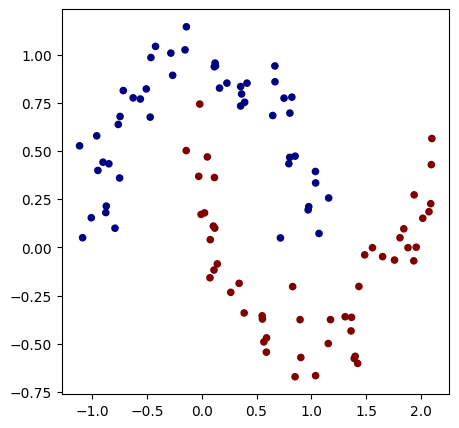

In [10]:
# make up dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y +/- 1
# visualize in 2d
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

array([ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,
       -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1,
        1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1])

In [14]:

# initialize a model
model = MLP(2, [16, 16, 1]) #  2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [30]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


Value(data=1.0521114496821748, grad=0) 0.5


In [31]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.0521114496821748, accuracy 50.0%
step 1 loss 0.9229228277329558, accuracy 70.0%
step 2 loss 0.8471446271717447, accuracy 69.0%
step 3 loss 1.195175610967316, accuracy 74.0%
step 4 loss 0.47351552789381185, accuracy 81.0%
step 5 loss 0.7361399883006564, accuracy 82.0%
step 6 loss 0.3575138688481414, accuracy 83.0%
step 7 loss 0.2983195555125503, accuracy 85.0%
step 8 loss 0.28134140693274773, accuracy 85.0%
step 9 loss 0.26567001350501446, accuracy 86.0%
step 10 loss 0.25878767186393764, accuracy 85.0%
step 11 loss 0.2501142297287069, accuracy 86.0%
step 12 loss 0.2417974373740069, accuracy 90.0%
step 13 loss 0.23533626807017297, accuracy 90.0%
step 14 loss 0.23232547776959847, accuracy 91.0%
step 15 loss 0.23520957010259638, accuracy 90.0%
step 16 loss 0.2544907873845773, accuracy 87.0%
step 17 loss 0.2137212016902005, accuracy 90.0%
step 18 loss 0.19929396863214394, accuracy 93.0%
step 19 loss 0.1976548372315566, accuracy 91.0%
step 20 loss 0.23053678304692596, accuracy 

(-1.6708631651078416, 2.079136834892158)

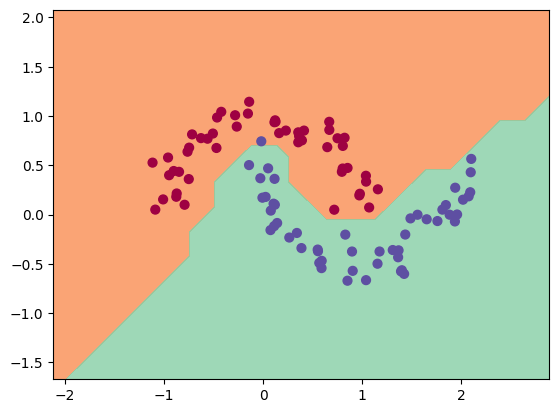

In [32]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())